In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
#from simsetup import get_sim
#from modelfitting import ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

In [4]:
dataset1 = pd.read_csv('SPOCKalt/secondMMRintData/fullFeature2MMRsPlusOuter.csv')
dataset2 = pd.read_csv('SPOCKalt/secondMMRintData/fullFeature2MMRsPlusOuter5thOrder.csv')
dataset1 = dataset1.iloc[25000:]
dataset2 = dataset2.iloc[25000:]


In [5]:
def hasnull(row):
    numnulls = row.isnull().sum()
    if numnulls == 0:
        return 0
    else:
        return 1

def tmax(row):
    #sim = get_sim(row, csvfolder)
    tmax = 1e4 # replace with a calculation of tmax
    return tmax

In [6]:
%%time
if 'hasnull' not in dataset1.columns:
    dataset1['hasnull'] = dataset1.apply(hasnull, axis=1)
if 'hasnull' not in dataset2.columns:
    dataset2['hasnull'] = dataset2.apply(hasnull, axis=1)

CPU times: user 9.13 s, sys: 63.4 ms, total: 9.2 s
Wall time: 9.2 s


In [7]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','twoMMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','twoMMRstrengthfar']
outer = ['EMcrossouter', 'EMfracstdouter', 'EPstdouter', 'MMRstrengthouter','twoMMRstrengthouter']
megno = ['MEGNO', 'MEGNOstd']
#what is being used to train
features = near + far + outer + megno
pfeatures = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear','EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar','MEGNO', 'MEGNOstd']
Oldfeatures = near + far + megno

In [8]:
mask = (dataset1['hasnull'] == 0 )
data1 = dataset1[mask]
mask = (dataset2['hasnull'] == 0 )
data2 = dataset2[mask]

In [9]:
Nrows = int(0.8*data1.shape[0])
train1 = data1.iloc[:Nrows, :]
test1 = data1.iloc[Nrows:, :]
train2 = data2.iloc[:Nrows, :]
test2 = data2.iloc[Nrows:, :]

In [10]:
resultBalance1 = train1['Stable'].value_counts()[False]/train1['Stable'].value_counts()[True]
resultBalance2 = train2['Stable'].value_counts()[False]/train2['Stable'].value_counts()[True]


In [11]:
realTest1 = test1.loc[test1['prelimStable']==True]
realTest2 = test2.loc[test2['prelimStable']==True]


In [12]:
from sklearn.metrics import accuracy_score

In [13]:
OuterModel1 = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance1)

OuterModel2 = XGBClassifier(learning_rate = 0.05, 
                         max_depth = 40, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 400,
                         scale_pos_weight=resultBalance2)

In [14]:
OuterModel1.fit(train1[features], train1["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [15]:
OuterModel2.fit(train2[features], train2["Stable"])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=40, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [16]:
resPred = OuterModel1.predict_proba(realTest1[features])[:,1]
outMMRAUC1 = metrics.roc_auc_score(realTest1['Stable'],resPred)
outMMRacc1 = accuracy_score(OuterModel1.predict(realTest1[features]), realTest1["Stable"])
print('2nd order')
print (metrics.roc_auc_score(realTest1['Stable'],resPred))
print(accuracy_score(OuterModel1.predict(realTest1[features]), realTest1["Stable"]))

2nd order
0.962717649474162
0.9065950315457413


In [17]:
resPred = OuterModel2.predict_proba(realTest2[features])[:,1]
outMMRAUC2 = metrics.roc_auc_score(realTest2['Stable'],resPred)
outMMRacc2 = accuracy_score(OuterModel2.predict(realTest2[features]), realTest2["Stable"])
print('5th order')
print (metrics.roc_auc_score(realTest2['Stable'],resPred))
print(accuracy_score(OuterModel2.predict(realTest2[features]), realTest2["Stable"]))

5th order
0.9667173964659711
0.9137421135646687


In [18]:
oneModel = XGBClassifier(learning_rate = 0.03, 
                         max_depth = 20, 
                         subsample = 0.95,
                         min_child_weight = 5,
                         n_estimators = 100,
                         scale_pos_weight=resultBalance1)
oneModel.fit(train1[pfeatures], train1["Stable"])
resPred = oneModel.predict_proba(realTest1[pfeatures])[:,1]
oneMMRAUC = metrics.roc_auc_score(realTest1['Stable'],resPred)
oneMMRacc = accuracy_score(oneModel.predict(realTest1[pfeatures]), realTest1["Stable"])
print('original spock at 2nd order')
print (metrics.roc_auc_score(realTest1['Stable'],resPred))
print(accuracy_score(oneModel.predict(realTest1[pfeatures]), realTest1["Stable"]))

original spock at 2nd order
0.948078645260755
0.8832807570977917


In [19]:
# oneModel = XGBClassifier(learning_rate = 0.03, 
#                          max_depth = 20, 
#                          subsample = 0.95,
#                          min_child_weight = 5,
#                          n_estimators = 100,
#                          scale_pos_weight=resultBalance1)
# oneModel.fit(train2[pfeatures], train1["Stable"])
# resPred = oneModel.predict_proba(realTest2[pfeatures])[:,1]
# oneMMRAUC = metrics.roc_auc_score(realTest2['Stable'],resPred)
# oneMMRacc = accuracy_score(oneModel.predict(realTest2[pfeatures]), realTest2["Stable"])
# print (metrics.roc_auc_score(realTest2['Stable'],resPred))
# print(accuracy_score(oneModel.predict(realTest2[pfeatures]), realTest2["Stable"]))

In [23]:
print('compaired to original spock model')
print(f'decrease in AOC: {((1-oneMMRAUC)-(1-outMMRAUC2))/(1-oneMMRAUC)}')
print(f'decrease in error: {((1-oneMMRacc)-(1-outMMRacc2))/(1-oneMMRacc)}')

compaired to original spock model
decrease in AOC: 0.3589804483881831
decrease in error: 0.26097972972972966


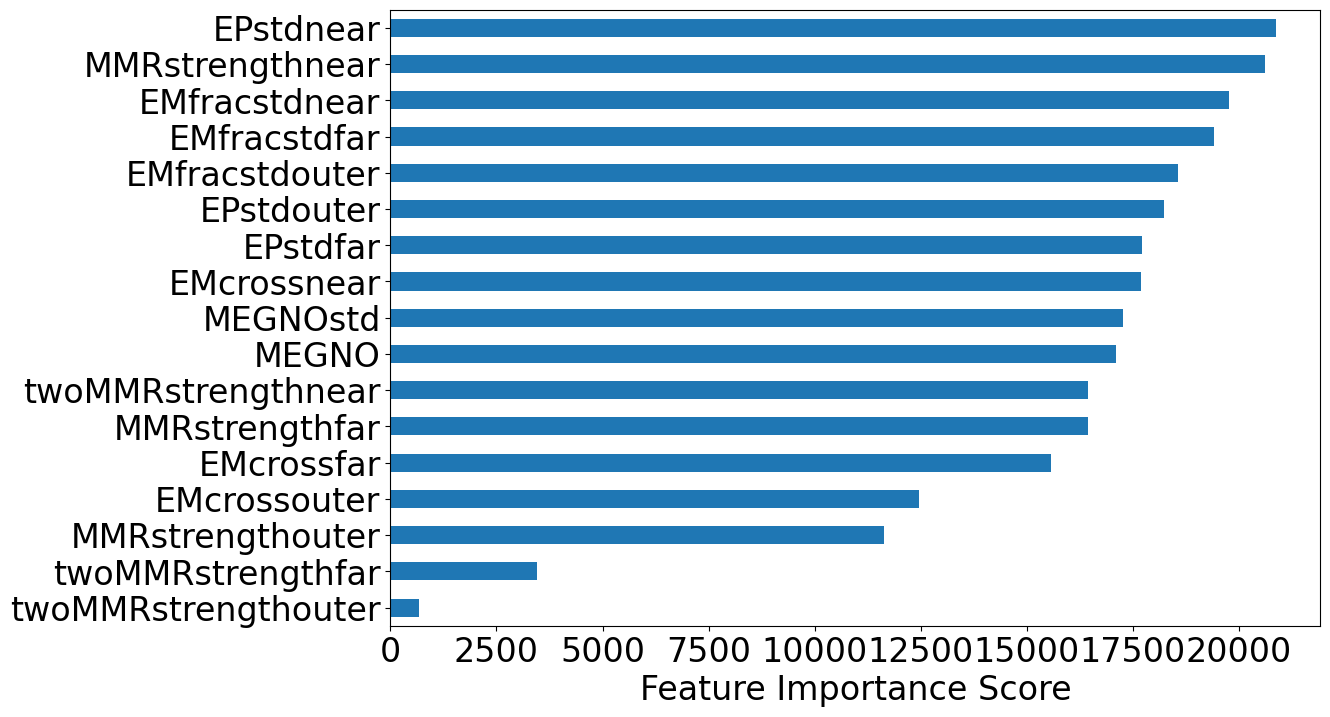

In [21]:
feat_imp = pd.Series(OuterModel1.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')

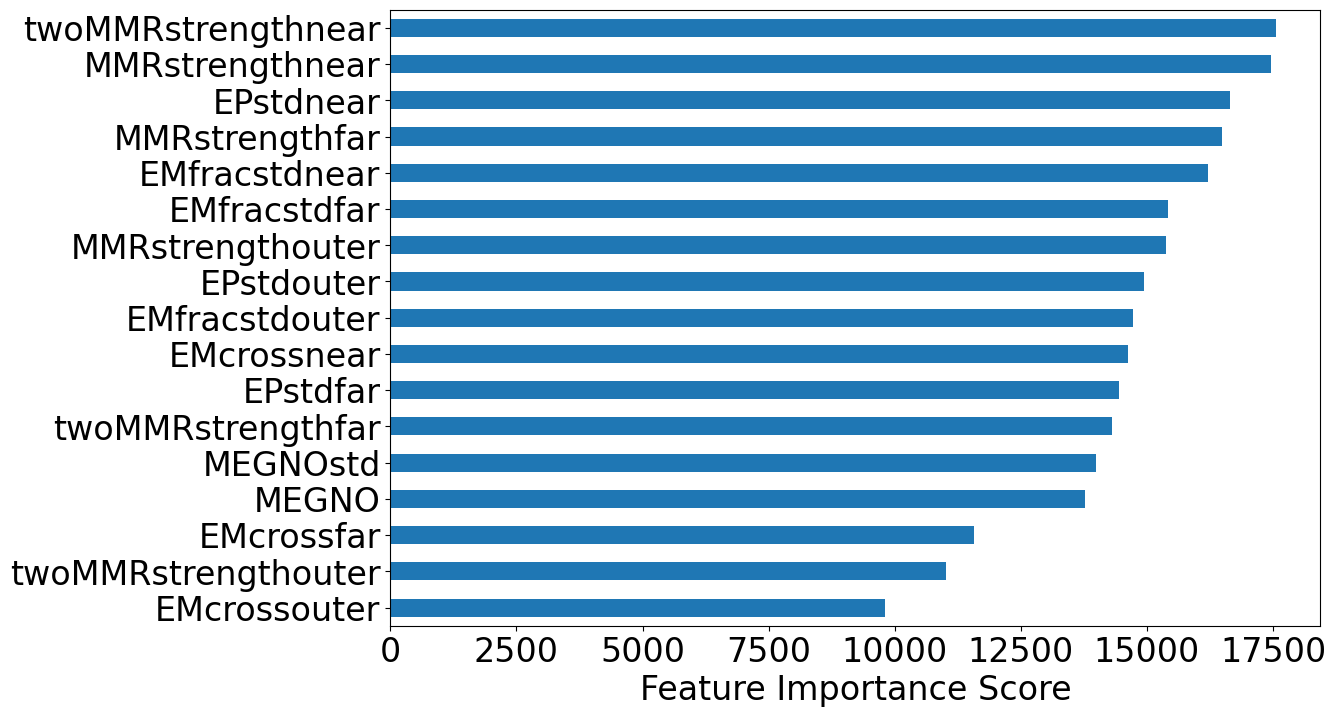

In [22]:
feat_imp = pd.Series(OuterModel2.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,8), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()
plt.savefig('featureimportances.pdf', bbox_inches='tight')